In [1]:
#import các thư viện
import pandas as pd
import numpy as np
%matplotlib inline 
#to plot the whatever graphic
import matplotlib.pyplot as plt #plot data
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [2]:
#import data VCB
df_VCB = pd.read_csv('../VCB-Historical-Data.csv')
df_VCB = df_VCB[['Date','Price']]
df_VCB

,Date,Price
0,1/2/2019,"41,161"
1,1/3/2019,"41,161"
2,1/4/2019,"41,775"
3,1/7/2019,"41,929"
4,1/8/2019,"42,236"
...,...,...
1107,6/12/2023,"101,000"
1108,6/13/2023,"102,500"
1109,6/14/2023,"102,600"
1110,6/15/2023,"103,500"


In [3]:
#import data VNI
df_VNI=pd.read_csv('../VN-Index-Historical-Data.csv')
df_VNI= df_VNI[['Date','Price']]
df_VNI

,Date,Price
0,1/2/2019,891.75
1,1/3/2019,878.22
2,1/4/2019,880.9
3,1/7/2019,889.64
4,1/8/2019,887.44
...,...,...
1107,6/12/2023,"1,116.02"
1108,6/13/2023,"1,122.46"
1109,6/14/2023,"1,117.42"
1110,6/15/2023,"1,116.97"


In [4]:
#Chuyển dữ liệu lần cuối, % thay đổi về dạng int
df_VCB['Price']=df_VCB['Price'].replace(',','',regex=True).astype(float)
df_VNI['Price']=df_VNI['Price'].replace(',','',regex=True).astype(float)

In [5]:
df = pd.merge(df_VCB, df_VNI, on='Date')
df.head()

,Date,Price_x,Price_y
0,1/2/2019,41161.0,891.75
1,1/3/2019,41161.0,878.22
2,1/4/2019,41775.0,880.90
3,1/7/2019,41929.0,889.64
4,1/8/2019,42236.0,887.44


In [6]:
name_mapping = {'Price_x':'Price_VCB','Price_y':'Price_VNI'}

In [7]:
df = df.rename(columns=name_mapping)
df

,Date,Price_VCB,Price_VNI
0,1/2/2019,41161.0,891.75
1,1/3/2019,41161.0,878.22
2,1/4/2019,41775.0,880.90
3,1/7/2019,41929.0,889.64
4,1/8/2019,42236.0,887.44
...,...,...,...
1107,6/12/2023,101000.0,1116.02
1108,6/13/2023,102500.0,1122.46
1109,6/14/2023,102600.0,1117.42
1110,6/15/2023,103500.0,1116.97


In [8]:
# data = data.reset_index(drop=True) # Reset the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Price_VCB', 'Price_VNI']]
df = df.dropna() # Drop missing values

# Split the df into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

889
111
112


In [9]:
train_exog = train_data[["Price_VNI"]]
model = auto_arima(train_data['Price_VCB'], 
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15107.428, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15109.405, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15111.160, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15111.163, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15108.199, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15114.666, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15114.581, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15109.030, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=15106.592, Time=0.96 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15114.028, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=15110.985, Time=1.14 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=15107.089, Time=0.76 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=15113.316, Time=0.37 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=15111.061, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0

In [10]:
model= SARIMAX(train_data['Price_VCB'], 
 exog=train_exog,
 order=(3,1,2),
 enforce_invertibility=False, enforce_stationarity=False)

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price_VCB'])
test_exog = test_data[['Price_VNI']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price_VCB'])
val_exog = val_data[['Price_VNI']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

889    72699.040917
890    72948.637094
891    73857.517528
892    73754.732197
893    75121.793586
           ...     
995    63612.774513
996    61696.658470
997    62752.622222
998    63357.510549
999    63010.067930
Name: predicted_mean, Length: 111, dtype: float64
            Price_VNI
Date                 
2022-12-30    1007.09
2023-01-03    1043.90
2023-01-04    1046.35
2023-01-05    1055.82
2023-01-06    1051.44
...               ...
2023-06-12    1116.02
2023-06-13    1122.46
2023-06-14    1117.42
2023-06-15    1116.97
2023-06-16    1115.22

[112 rows x 1 columns]
889     62991.374152
890     64923.094405
891     65034.002231
892     65545.377635
893     65308.857707
            ...     
996     68831.504461
997     69182.765131
998     68907.865476
999     68883.320864
1000    68787.869595
Name: predicted_mean, Length: 112, dtype: float64


c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [12]:
# Tính độ đo MDA trên tập test
y_test_actual = np.array(test_data['Price_VCB'])
y_test_predicted = y_pred
test_correct = np.where(np.sign(np.diff(y_test_actual)) == np.sign(np.diff(y_test_predicted)), 1, 0)
test_mda = np.mean(test_correct)
# Tính độ đo MDA trên tập validation
y_val_actual = np.array(val_data['Price_VCB'])
y_val_predicted = y_pred_val
val_correct = np.where(np.sign(np.diff(y_val_actual)) == np.sign(np.diff(y_val_predicted)), 1, 0)
val_mda = np.mean(val_correct)

Validation RMSE: 25922.56
Testing RMSE: 9569.81
Validation MAPE: 27.92%
Testing MAPE: 10.23%
Testing MDA: 73.64%
Validation MDA: 67.57%


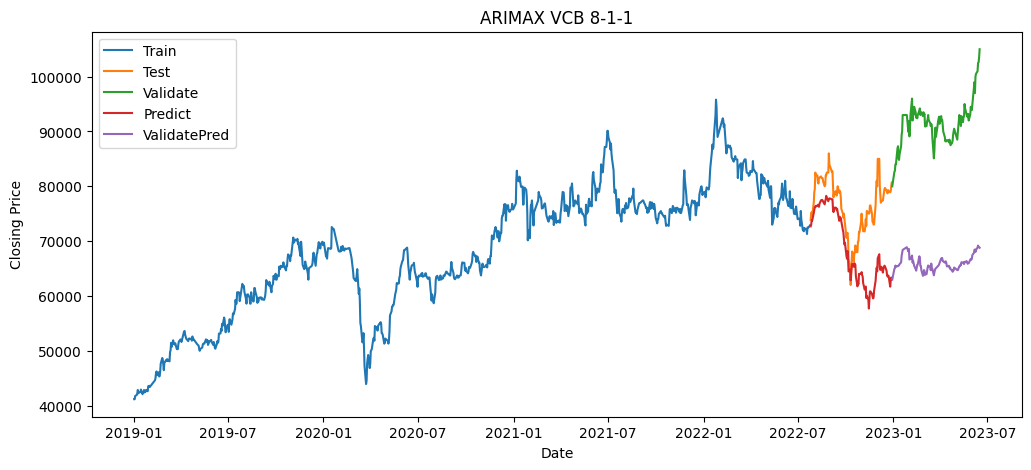

In [13]:
# 8. Tính các độ đo
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
valid_mae = mean_absolute_error(y_pred_val,y_val) # MAE
test_mae = mean_absolute_error(y_pred,y_test)
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print(f"Testing MAPE: {test_mape*100:.2f}%")
print(f"Testing MDA: {test_mda*100:.2f}%")
print(f"Validation MDA: {val_mda*100:.2f}%")
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('ARIMAX VCB 8-1-1')
plt.plot(train_data.index, train_data['Price_VCB'])
plt.plot(test_data.index, test_data['Price_VCB'])
plt.plot(val_data.index, val_data['Price_VCB'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
#plt.plot(next_30_days_index,y_next_30_days)
#plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.legend(['Train', 'Test', 'Validate','Predict','ValidatePred'])
plt.show()